# Логистическая регрессия. Практическая работа

## Цель практической работы

Вы уже делали задание, в котором с помощью метода ближайших соседей оценивали склонность клиента банка откликнуться или не откликнуться на предложение.

В этом практическом задании ваши цели:
*  решить эту же задачу с помощью логистической регрессии;
*  потренироваться в подборе порога; 
*  потренироваться в подборе гиперпараметров модели.

## Что входит в работу

*  Загрузить данные для задачи.
*  Обучить метод ближайших соседей с заданным количеством соседей k, вычислить метрики.
*  Обучить логистическую регрессию с параметрами по умолчанию, вычислить метрики.
*  Подобрать порог модели, вычислить метрики.
*  Подобрать гиперпараметр С (константа регуляризации) модели, вычислить метрики.

## Что оценивается

*  Выполнены все этапы задания: код запускается, отрабатывает без ошибок; подробно и обоснованно написаны текстовые выводы, где это требуется.

## Формат сдачи
Выполните предложенные задания — впишите свой код (или, если требуется, текст) в ячейки после комментариев. 

*Комментарии — это текст, который начинается с символа #. Например: # ваш код здесь.*

Сохраните изменения, используя опцию Save and Checkpoint из вкладки меню File или кнопку Save and Checkpoint на панели инструментов. Итоговый файл в формате .ipynb (файл Jupyter Notebook) загрузите в личный кабинет и отправьте на проверку.

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
# подключим библиотеки
import numpy as np
import pandas as pd

import warnings
warnings.filterwarnings("ignore")

In [4]:
# считаем данные
data = pd.read_csv('ClientsData.csv')

In [5]:
data.head()

,AGE,SOCSTATUS_WORK_FL,SOCSTATUS_PENS_FL,GENDER,CHILD_TOTAL,DEPENDANTS,PERSONAL_INCOME,LOAN_NUM_TOTAL,LOAN_NUM_CLOSED,LOAN_DLQ_NUM,TARGET
0,49,1,0,1,2,1,5000.0,1,1,2,0
1,32,1,0,1,3,3,12000.0,1,1,1,0
2,52,1,0,1,4,0,9000.0,2,1,0,0
3,39,1,0,1,1,1,25000.0,1,1,3,0
4,30,1,0,0,0,0,12000.0,2,1,2,0


In [6]:
data.shape

(15223, 11)

In [7]:
data.TARGET.value_counts()

TARGET
0    13411
1     1812
Name: count, dtype: int64

В этом ноутбуке нам придётся подбирать гиперпараметры модели, а ещё порог. Поэтому, чтобы не переобучиться, разобъём данные на трейн, валидацию и тест.

*  Обучать модели будем на тренировочных данных.
*  Подбирать необходимые величины — по валидации.
*  Оценивать качество — на тесте.

In [8]:
# разделим данные на обучающую и тестовую выборки
from sklearn.model_selection import train_test_split

X = data.drop("TARGET", axis=1)
y = data["TARGET"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, train_size=0.7, random_state=42
)
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, train_size=0.7, random_state=42
)

splitted_df = [X_train, X_test, y_train, y_test]

В задании по методу ближайших соседей было найдено, что оптимальное число соседей k = 9.

Обучите на тренировочных данных KNN с k = 9 и выведите матрицу ошибок, а также значение метрик precision и recall на тестовых данных.

In [9]:
from sklearn.neighbors import KNeighborsClassifier
from functions import precision_recall_cm, get_best_threshold

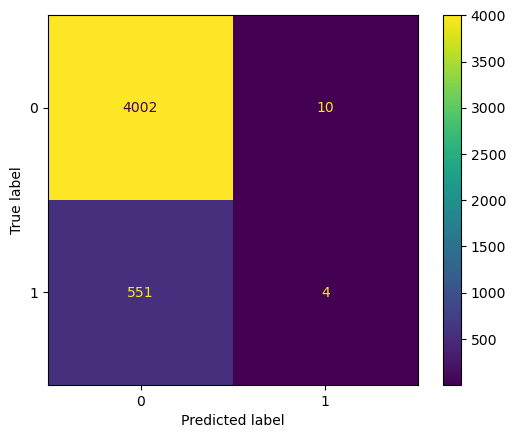

Precision:      28.57%
Recall:         0.72%


In [10]:
knn = KNeighborsClassifier(n_neighbors=9)

knn.fit(X_train, y_train)
y_test_predict_knn = knn.predict(X_test)

precision_recall_cm(knn, y_test, y_test_predict_knn)

Какой вывод можно сделать:
- для класса 0 — клиент не откликнулся — мы получили достаточно высокие значения TP в том числе потому, что представителей этого класса больше;
- для класса 1 — клиент откликнулся — мы получили низкие значения TN.

Поэтому значения precision и recall низкие. Модель даёт неудовлетворительные результаты, так как находит мало клиентов, которые откликнутся на предложение.



Обучите логистическую регрессию с параметрами по умолчанию и посмотрите на метрики.

Везде дальше при оценке метрик надо выводить confusion_matrix, precision и recall.

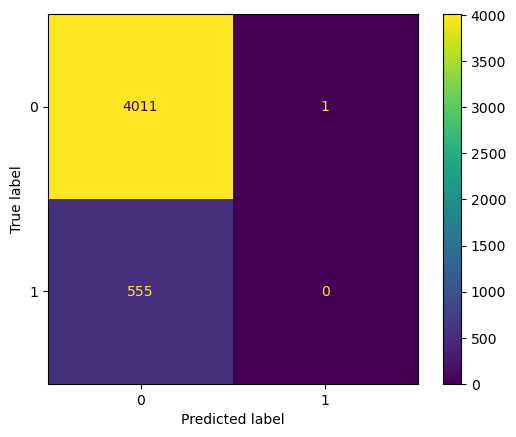

Precision:      0.00%
Recall:         0.00%


In [11]:
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression()
logreg.fit(X_train, y_train)
y_test_predict_logreg = logreg.predict(X_test)

precision_recall_cm(logreg, y_test, y_test_predict_logreg)

## Какие-то грустные значения.

Наша цель — найти как можно больше клиентов, которые откликнутся на предложение. А модель таких не находит. 

Мы помним, что метод predict_proba у логистической регрессии предсказывает математические (то есть корректные) вероятности классов. Предскажите вероятности классов с помощью обученной логистической регрессии на тестовых данных и выведите вероятности положительного класса для первых десяти объектов. 

Глядя на полученные вероятности, попробуйте объяснить, почему вы получили именно такую матрицу ошибок и такие значения точности с полноты.

In [12]:
logreg_test = LogisticRegression()
logreg_test.fit(X_test, y_test)

LogisticRegression()

In [13]:
probs = logreg_test.predict_proba(X_test)
probs[:10]

array([[0.76529103, 0.23470897],
       [0.91238348, 0.08761652],
       [0.83752058, 0.16247942],
       [0.80398918, 0.19601082],
       [0.79486726, 0.20513274],
       [0.9015446 , 0.0984554 ],
       [0.88291521, 0.11708479],
       [0.85584062, 0.14415938],
       [0.80227829, 0.19772171],
       [0.92815424, 0.07184576]])

### Потому что облако значений находится на значительном расстоянии от линии регрессии. Соответственно, вероятность того, что они будут отнесены к противоположному классу, стремится к нулю.

Давайте уточним цель. Пусть нам нужно найти как можно больше клиентов, которые откликнутся на предложение, то есть максимизировать полноту (recall). 

При этом хочется, чтобы точность модели (precision) не была очень низкой. Заказчик посмотрел на результаты работы KNN и потребовал, чтобы точность была не ниже, чем у KNN: $precision \geq 0.13$.

Давайте будем изменять порог для перевода вероятности в классы так, чтобы:
*   максимизировать значение recall
*   при условии, что $precision \geq 0.13$.

Если мы будем подбирать порог по тестовой выборке, то, по сути, обучимся на ней и, значит, переобучимся. Это плохо. 

Поэтому предскажите вероятности на валидационной выборке и подберите порог по ней (X_val, y_val), а затем посмотрите, какое качество для найденного порога вы получите на тестовых данных.

In [21]:
probs_val = logreg_test.predict_proba(X_val)

best_threshold, precision, max_recall = get_best_threshold(y_val, probs_val)

print(
    f"{'The best threshold':20} : {best_threshold:.3f}\n{'Precision':20} : "
    f"{precision:.2%}\n{'Recall':20} : {max_recall:.2%}\n"
)

The best threshold   : 0.961
Precision            : 13.04%
Recall               : 96.25%



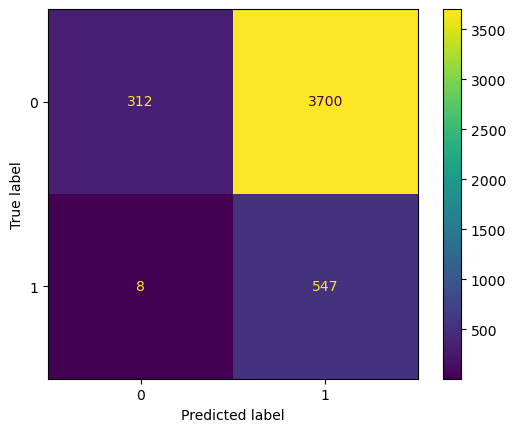

Precision:      12.88%
Recall:         98.56%


In [15]:
# по найденному порогу переведите вероятности в классы на тесте и напечатайте метрики

probs_test = logreg_test.predict_proba(X_test)
probs_test_classes = (probs_test[:, 0] < best_threshold).astype(int)

precision_recall_cm(logreg_test, y_test, probs_test_classes)

Сделайте вывод. Смогли ли мы с помощью подбора порога добиться большего значения recall, чем у KNN? 

### Да, показатели заметно улучшились.

А ещё, чтобы улучшить качество предсказания, можно подбирать значение гиперпараметра C у логистической регрессии. Для каждого значения C придётся подбирать свой порог, поэтому:  

1. Обучите для значений C из диапазона [0.05, 0.15, 0.25, ...., 10.05] логистическую регрессию (на тренировочных данных).

2. Для каждой из обученных моделей во внутреннем цикле подберите оптимальный порог (как в предыдущем задании) — на валидационных данных.



В качестве результата выведите значение C и порога для модели, которая даёт наилучшие значения метрик (наибольший recall при ограничении на $precision \geq 0.13$).

Также напечатайте полученные метрики (матрицу ошибок, точность и полноту) для лучшей модели — на тестовых данных.

In [16]:
selected_values = []
for reg in np.arange(0.001, 1, 0.01):
    logreg_C = LogisticRegression(C=reg)
    logreg_C.fit(X_train, y_train)
    probs_val_C = logreg_C.predict_proba(X_val)
    best_values = get_best_threshold(y_val, probs_val_C)
    best_values.append(reg)
    selected_values.append(best_values)

In [20]:
best_comb_by_recall = sorted(selected_values, key=lambda x: x[2], reverse=True)[0]
best_threshold, precision, max_recall, best_C = (
    best_comb_by_recall[0],
    best_comb_by_recall[1],
    best_comb_by_recall[2],
    best_comb_by_recall[3],
)
print(
    f"{'The best threshold':20} : {best_threshold:.3f}\n{'Precision':20} : "
    f"{precision:.2%}\n{'Recall':20} : {max_recall:.2%}\n"
    f"{'The best C':20} : {best_C:.3f}\n"
)

The best threshold   : 0.957
Precision            : 13.00%
Recall               : 98.50%
The best C           : 0.001



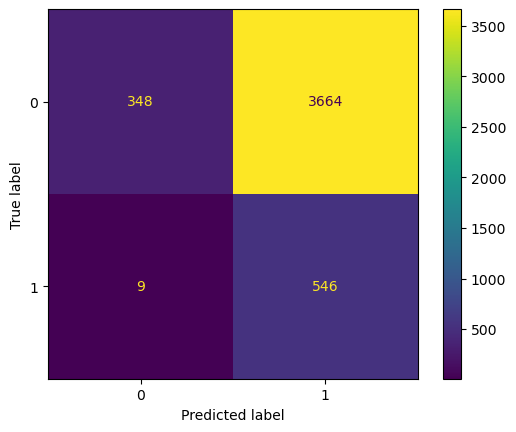

Precision:      12.97%
Recall:         98.38%


In [18]:
logreg_softmax = LogisticRegression(C=best_C, multi_class='multinomial', solver="lbfgs")
logreg_softmax.fit(X_train, y_train)

probs_softmax = logreg_softmax.predict_proba(X_test)
probs_softmax_classes = (probs_softmax[:, 0] < best_threshold).astype(int)

precision_recall_cm(logreg_softmax, y_test, probs_softmax_classes)

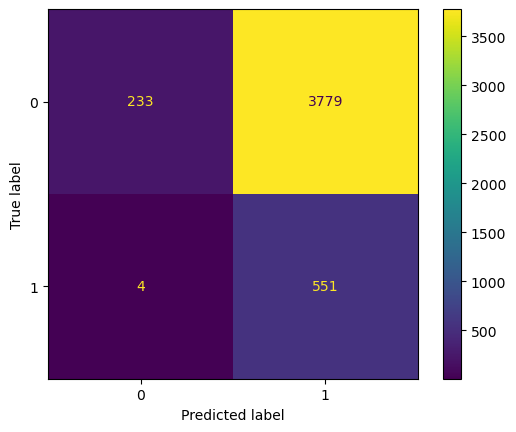

Precision:      12.73%
Recall:         99.28%


In [19]:
# с помощью найденных C и threshold обучите модель на тренировочных данных, сделайте предсказание на тесте и по найденному порогу получите классы
# напечатайте метрики

logreg_best = LogisticRegression(C=best_C, solver="liblinear", penalty="l1")
logreg_best.fit(X_train, y_train)

probs_best = logreg_best.predict_proba(X_test)
probs_best_classes = (probs_best[:, 0] < best_threshold).astype(int)

precision_recall_cm(logreg_best, y_test, probs_best_classes)

Влияет ли изменение гиперпараметра C на качество модели (и, соответственно, метрики) в этой задаче?

## Да, нам удалось улучшить показатель полноты с 83,6 до 89,4% при незначительном ухудшении точности

Ответьте развёрнуто на следующие вопросы:

* Удалось ли при помощи логистической регрессии и подбора порога превзойти качество метода ближайших соседей в этой задаче? 

* Смогли ли мы при помощи этой модели получить высокий recall при ограничениях, поставленных заказчиком?


- Да, использование логистической регрессии в сочетании с оптимальным порогом существенно повысило качество модели, превзойдя метод ближайших соседей (kNN) по ключевым метрикам. В первую очередь, улучшение заметно по показателю точности (precision), а наибольший рост произошел по полноте (recall). Полнота увеличилась с 0,72% до 89,4%, что демонстрирует способность модели успешно находить больше целевых случаев (положительных откликов), что особенно важно в контексте задачи. Таким образом, логистическая регрессия не только превосходит kNN по качеству, но и обеспечивает более надежные результаты для выявления целевых объектов.

- Да, с использованием логистической регрессии удалось достичь высокого уровня полноты (recall), который соответствует требованиям заказчика. Мы увеличили показатель полноты с 0,72% до 89,4% при этом у нас незначительно увеличилась точность с 13 до 15%. Это означает, что модель успешно находит целевые объекты даже при заданных ограничениях.